In [1]:
import xpress as xp
from functions_watervalues import *

In [2]:
%matplotlib widget

In [3]:
dir_study = "D:/Users/gerbauxjul/Documents/6-Etudes Antares/OneNodeBase_ref"
name_area = "area"

t1 = ThermalUnit(0.1,100,10000,1000,42500.0,"1")
t2 = ThermalUnit(0.2,100,10000,100,12500.0,"2")
t3 = ThermalUnit(0.3,500,2000,1000,7500.0,"3")

area = Area([t1,t3],[],dir_study,name_area, "area")

NTrain = 5
study = Study([area],2.99,0,3,NTrain, {})

In [20]:
model = xp.problem()
model.controls.xslp_log = -1

total_cost = [0]*H

imports = {}
exports = {}
for area in study.list_areas:
    imports[area.name] = [0]*H
    exports[area.name] = [0]*H
for a1 in study.list_areas:
    for a2 in study.list_areas:
        if (a1.name in study.links) and (a2.name in study.links[a1.name]):
            exchange = [xp.var(f"exchange_{a1.name}_{a2.name}_{h}",lb = 0, ub =  study.links[a1.name][a2.name][0]) for h in range(H)] 
            model.addVariable(exchange)
            for h in range(H):
                imports[a2.name][h] += exchange[h]
                exports[a1.name][h] += exchange[h]
                total_cost[h] += exchange[h]*study.links[a1.name][a2.name][1]



# CONTROLS
# Thermal
for area in study.list_areas:

    total_prod = [0]*H

    # LOAD
    w = [xp.var(f"load_{area.name}_{i}",lb = float('-inf'), ub =  float('inf')) for i in range(H)]
    model.addVariable (w) # Uncertain

    for thermal_unit in area.list_thermal_units :
        t = [xp.var(f"t_{area.name}_{thermal_unit.name}_{i}",lb = 0, ub =  thermal_unit.P_max) for i in range(H)]
        model.addVariable (t) 
        state_on = [xp.var(f"on_{area.name}_{thermal_unit.name}_{i}",vartype=xp.binary) for i in range(H)]
        model.addVariable (state_on) 
        start_up = [xp.var(f"up_{area.name}_{thermal_unit.name}_{i}",vartype=xp.binary) for i in range(H)]
        model.addVariable (start_up)
        for h in range(H):
            total_prod[h] += t[h]
            total_cost[h] += t[h]*thermal_unit.marginal_cost 
            total_cost[h] += state_on[h]*thermal_unit.fixed_cost
            total_cost[h] += start_up[h]*thermal_unit.start_up_cost
            model.addConstraint(state_on[h]*thermal_unit.P_min<=t[h])
            model.addConstraint(t[h]<=state_on[h]*thermal_unit.P_max)
            if h>=1:
                model.addConstraint(start_up[h]>=state_on[h]-state_on[h-1])
            else :
                model.addConstraint(start_up[h]>=state_on[h])
            if h<H-3:
                total_prod[h] += start_up[h+1]*thermal_unit.P_min+start_up[h+2]*thermal_unit.P_min+start_up[h+3]*thermal_unit.P_min/2 # courbe de démarrage
            # if h>=1:
            #     model.addConstraint(state_on[h]>=start_up[h]+start_up[h-1]) # min on
            if h>=2:
                model.addConstraint(1-state_on[h-2]>=start_up[h]+start_up[h-1]) # min down
                

    
    # Not served energy
    ens = [xp.var(f"ens_{area.name}_{i}") for i in range(H)]
    model.addVariable (ens)                    # Energy not served 
    for h in range(H):
        total_cost[h] += ens[h]*study.cost_ens

    spill = [xp.var(f"spill_{area.name}_{i}") for i in range(H)]
    model.addVariable (spill) # Energy excess

    # Interco
                        

    # Energy balnce
    surplus_thermic = [xp.var(f"surplus_thermic_{area.name}_{h}",lb = float('-inf'), ub =  float('inf')) for h in range(H)]
    model.addVariable(surplus_thermic)
    for h in range(H):
        model.addConstraint(surplus_thermic[h] == total_prod[h] + ens[h] + imports[area.name][h] - w[h] - spill[h] - exports[area.name][h])
        model.addConstraint(surplus_thermic[h] == 0)

cost_thermic = xp.var("cost_thermic",lb = float('-inf'), ub =  float('inf'))
model.addVariable(cost_thermic)
model.addConstraint(cost_thermic==xp.Sum(total_cost))
model.setObjective(xp.Sum(cost_thermic))   

In [21]:
s = 0
k = 0

In [22]:
for a in study.list_areas:
    model.chgbounds([f"load_{a.name}_{j}" for j in range(H)]*2,['L']*H+['U']*H,list(a.load[s,:,k])+list(a.load[s,:,k]))

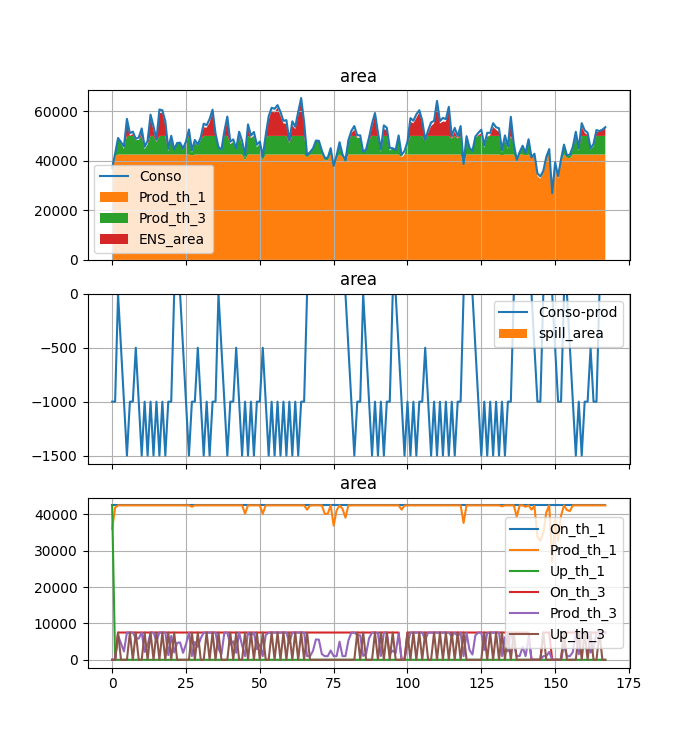

In [23]:
solve_and_plot(model,study,s,0)

In [ ]:
for s in range(51,-1,-1):
    for k in range(study.nb_mc): # chronicle boucle w 
        for a in study.list_areas:
            model.chgbounds([f"load_{a.name}_{j}" for j in range(H)]*2,['L']*H+['U']*H,list(a.load[s,:,k])+list(a.load[s,:,k]))
        # return(model, s, X[i])
        model.solve()